# Magnetic and Diagenetic Analyses of Gai et al. (2020)
_____

Paper doi: https://doi.org/10.1016/j.epsl.2019.115960

Core: IODP Expedition 349, Hole U1431D, 15°22.54′ N, 117°00.01′ E.

Water depth: 4240 m

Data in analysis: Magnetite wt. % (from Ms measurements), sedimentation rate, total organic carbon, pore water chemistry.

The TOC data is pretty sparse for the upper 100 meters (seems like it's generally low though).

In [1]:
# Import data and plotting tools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # for legend creation
import numpy as np
%matplotlib inline
import data_fns
plt.rcParams["font.family"] = "Avenir"

In [2]:
# read data into pandas, one DataFrame per sheet
Ms = pd.read_excel("data/gai2020.xlsx", sheet_name="normalized Ms")
tie_points = pd.read_excel("data/gai2020.xlsx", sheet_name="age points")


# combining data from different holes (they are 60m apart)
# don't need to sort them, because they will get sorted before interpolation
combined_geochem = pd.read_excel("data/gai2020.xlsx", sheet_name="1431A geochem").append(pd.read_excel("data/gai2020.xlsx", sheet_name="1431D geochem"), ignore_index=True)
combined_TOC = pd.read_excel("data/gai2020.xlsx", sheet_name="1431A TOC").append(pd.read_excel("data/gai2020.xlsx", sheet_name="1431D TOC"), ignore_index=True)

# in the TOC sheet, set any "bdl" points to 0.03 (lowest recorded value)
# also replace empty strings with np.nan
combined_TOC["Organic carbon (wt%) by difference (CHNS-COUL)"].replace(to_replace={"bdl":0.03, " ":np.nan}, inplace=True)
combined_geochem["Sulfate (mM)IC "].replace(to_replace={" ":np.nan}, inplace=True)

# unit adjustments--Ms (uAm^2/g) to magnetite ppm
# multiply by 1000 for g->kg, divide by 1000000 for uA->A
# divide by 92 for Ms-> fraction, multiply by 10^6 for weight fraction->ppm
Ms["Magnetite [ppm]"] = (Ms["normalized Ms(uAm²/g)"] * 1000 * 10**6) / (1000000 * 92)


It can be tricky to compare different data sets to each other since they are not measured at the same depths. Ex: you might have a magnetite point at 63.5 mbsf, but the closest TOC points are at 61.8 and 65 mbsf. What do you do? (Not a rhetorical question--we chose linear interpolation)

Also, we convert $M_s$ $(\frac{Am^2}{kg})$ into magnetite weight percent using the methodology from [Lascu et al. (2010)](https://doi.org/10.1029/2010GC003182). Assuming magnetite is the only magnetic phase present (which is sometimes an acceptable assumption--see discussion), our formula is:

$$f_{ferri} = \frac{M_s}{\mu_{ferri}}$$

Using a value of 92 $\frac{Am^2}{kg}$ for magnetite's $M_s$ (based on physics), we convert by dividing by 92.

In [4]:
# calculate sed rates
# using just 2 sed rates b/c that is consistent with paper's interpretation
sed_rates = data_fns.sed_rates(tie_points["Lower boundary age (Ma)"], tie_points["Depth (mbsf)"])

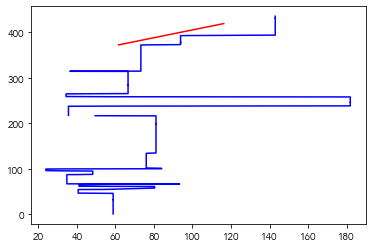

In [5]:
# we could have also calculated sed rates from the ages given in the Ms sheet
other_rates = data_fns.sed_rates(Ms["age (Ma)"], Ms["depth (mbsf)"])
# as you can see from this comparison, the rates don't totally line up
# red is smoother, so using that
plt.plot(other_rates, Ms["depth (mbsf)"], "b-")
plt.plot(sed_rates, tie_points["Depth (mbsf)"], "r-")

In [6]:
# build DFs
magn_df = pd.DataFrame({"Depth [mbsf]":Ms["depth (mbsf)"], "Magnetite [ppm]":Ms["Magnetite [ppm]"]})
TOC_df = pd.DataFrame({"Depth [mbsf]":combined_TOC["Top depth CSF-A (m)"], "TOC [wt. %]":combined_TOC["Organic carbon (wt%) by difference (CHNS-COUL)"]})
geochem_df = pd.DataFrame({"Depth [mbsf]":combined_geochem["Top depth CSF-A (m)"], "Sulfate [mM]":combined_geochem["Sulfate (mM)IC "]})
sed_df = pd.DataFrame({"Depth [mbsf]":tie_points["Depth (mbsf)"], "Sedimentation Rate [m/Ma]":sed_rates})

# combine
# adding the extra step of dropping rows that are all NaN (e.g. not even depth measured)
# this is because we need a depth measured in every row for interpolation
comb_df = magn_df.append(TOC_df).append(geochem_df).append(sed_df).sort_values(by="Depth [mbsf]").reset_index(drop=True).dropna(how="all")

# interpolate: pass in columns other than sed rate
interpolated = data_fns.interpolate(comb_df, ["Sulfate [mM]", "TOC [wt. %]"])


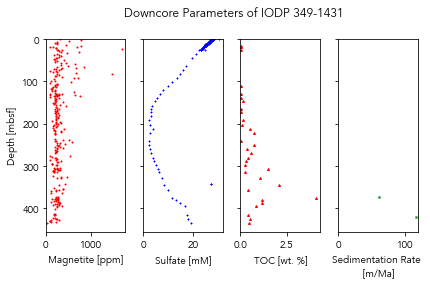

In [7]:
# downcore plots
colors = ["r", "b", "r", "g"]
markers = [".", "+", "^", "x"]
dc_fig, dc_axs = data_fns.plot_dc(["Magnetite [ppm]", "Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Ma]"], comb_df, colors, markers)
dc_axs[3].set_xlabel("Sedimentation Rate \n [m/Ma]")
#dc_axs[0].set_xticks([0, 500, 1000, 1500])
#dc_axs[0].set_xlim(0, 1000)
dc_fig.suptitle("Downcore Parameters of IODP 349-1431", x=0.55)
dc_fig.tight_layout()
dc_fig.savefig("outputs/gai2020/1431-dc.pdf")

Next we want to think about different factors and their diagenetic effects on magnetite. Do increased pore water sulfate levels cause increased dissolution of magnetite? What about the presence of organic carbon? Do high sedimentation rates help preserve magnetite? We will plot magnetite concentration against each of these factors.

Measurements in these data sets are not taken at all the same depths as Ms measurements. A simple way to interpolate the geochemistry data is to assume a linear fit between data points. Then we can calculate associated geochem values for every Ms point. **Assuming a linear fit might not always be great, especially for outlier points.**

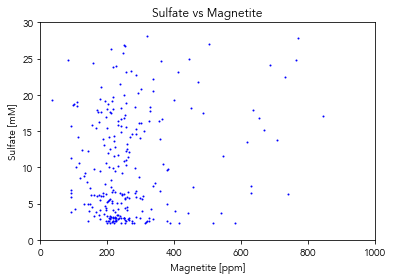

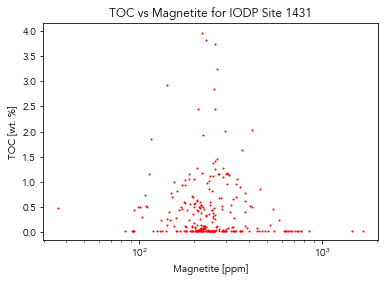

In [10]:
# comparison plots
comp_figs, comp_axs = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]"], interpolated, ["b", "r"], [".", "."])

# labeling
comp_axs[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite", xscale="linear", xlim=[0,1000], ylim=[0,30])
comp_axs[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite for IODP Site 1431", xscale="log")

# saving
comp_figs[0].savefig("outputs/gai2020/gai2020_sulf-comp-zoom.pdf")
comp_figs[1].savefig("outputs/gai2020/gai2020_toc-comp.pdf")

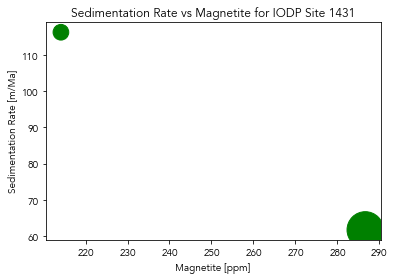

In [10]:
# sed rates comp plot
sed_fig, sed_ax, sed_sc = data_fns.sed_avg_plot(interpolated, 6)
sed_ax.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Ma]", title = "Sedimentation Rate vs Magnetite for IODP Site 1431")
sed_fig.savefig("outputs/gai2020/gai2020_sed-comp-binned.pdf")

In [11]:
# compile results and add to compilation docs
data_fns.write_output(interpolated, "IODP 349-1431", "data/comp_inter.xlsx")
data_fns.write_output(comb_df, "IODP 349-1431", "data/comp_raw.xlsx")
